## Setting the correct path

In [1]:
import os

model_path = os.path.join(os.getcwd(), 'saved_models')
cifar_working_dir = os.path.dirname(os.path.dirname(model_path))
src_path = os.path.dirname(os.path.dirname(cifar_working_dir))
explanation_path = os.path.join(os.path.dirname(model_path), 'explanation_files')
explanation_heatmap_path = os.path.join(os.path.dirname(model_path), 'explanation_heatmaps')
sanity_checks_output = os.path.join(os.path.join(os.getcwd(), 'sanity_checks'))


print('model_path ', model_path)
print('cifar_working_path ', cifar_working_dir)
print('src_path ', src_path)
print('explanation_path ', explanation_path)
print('explanation_heatmap_path ', explanation_heatmap_path)
print('sanity_checks folder ', sanity_checks_output)

model_path  D:\Mihir\MT\Code\cifar\GBP_explanation\dropout\saved_models
cifar_working_path  D:\Mihir\MT\Code\cifar\GBP_explanation
src_path  D:\Mihir\MT\Code
explanation_path  D:\Mihir\MT\Code\cifar\GBP_explanation\dropout\explanation_files
explanation_heatmap_path  D:\Mihir\MT\Code\cifar\GBP_explanation\dropout\explanation_heatmaps
sanity_checks folder  D:\Mihir\MT\Code\cifar\GBP_explanation\dropout\sanity_checks


## Imports

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import cv2
import re
import time
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf

import os
import seaborn as sns
import random 
import math

from keras.layers import *
from keras.models import Model, Sequential
import keras.backend as K

print(tf.__version__)
print(f'Eager execution enabled : {tf.executing_eagerly()}')

import sys
sys.path.insert(0,src_path)

from src.utils import *

np.set_printoptions(suppress=True)

2.8.0
Eager execution enabled : True


## Load data

In [3]:
(x_train, y_train), (x_test, y_test), train_generator, validation_generator, test_generator = load_cifar(num_classes = 10,
val_split = 0.95,
rotation_range = 0.2,
width_shift_range = 0.1, 
height_shift_range = 0.1,
shear_range = 0.1,
zoom_range = 0.1,
horizontal_flip = True ,
vertical_flip = False,

rescale = 1/255.,
train_batch_size=2048,
val_batch_size=2048,
test_batch_size=1)                                                                                                        

#
print(train_generator.x[9])
print(train_generator.y[9])

print(validation_generator.x[9])
print(validation_generator.y[9])

print(test_generator.x[9])
print(test_generator.y[9])

number of examples in train generator  50000
number of examples in val generator  9500
number of examples in test generator  500
[[[0.49019608 0.49019608 0.45490196]
  [0.43137255 0.39607844 0.35686275]
  [0.4        0.3529412  0.3254902 ]
  ...
  [0.7921569  0.8117647  0.8392157 ]
  [0.78431374 0.8039216  0.83137256]
  [0.7921569  0.8156863  0.8392157 ]]

 [[0.5568628  0.57254905 0.5568628 ]
  [0.57254905 0.5647059  0.54509807]
  [0.6901961  0.6745098  0.6666667 ]
  ...
  [0.7647059  0.7882353  0.8039216 ]
  [0.7764706  0.8039216  0.81960785]
  [0.8        0.827451   0.84313726]]

 [[0.7058824  0.7254902  0.7176471 ]
  [0.56078434 0.57254905 0.57254905]
  [0.6117647  0.6156863  0.6156863 ]
  ...
  [0.47843137 0.43529412 0.44313726]
  [0.54509807 0.5019608  0.5137255 ]
  [0.61960787 0.5764706  0.5882353 ]]

 ...

 [[0.40784314 0.32156864 0.16078432]
  [0.39607844 0.3137255  0.15294118]
  [0.39607844 0.31764707 0.14901961]
  ...
  [0.49411765 0.40392157 0.2627451 ]
  [0.49411765 0.40392

## Class definitions : StochasticModel & StochasticClassifier

In [4]:
import numpy as np
import tensorflow as tf 
import tensorflow.keras.backend as K

Layer = tf.keras.layers.Layer
Dropout = tf.keras.layers.Dropout

class StochasticDropout(Dropout):
    """
        Applies Dropout to the input, independent of the training phase.
        Used to easily implement MC-Dropout. It is a drop-in replacement for
        the standard Keras Dropout layer, but note that this layer applies
        dropout at the training and inference phases.
    """
    def __init__(self, rate, noise_shape=None, seed=None, **kwargs):
        super(StochasticDropout, self).__init__(rate, noise_shape, seed, **kwargs)
    
    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            noise_shape = self._get_noise_shape(inputs)

            return K.dropout(inputs, self.rate, noise_shape, seed=self.seed)

        return inputs

    def get_config(self):
        # this code is added so that the model can be saved even after making use of a custom layer 
        # https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object
        config = super(StochasticDropout, self).get_config()
        config.update({'rate': self.rate})
        return config


class StochasticModel:
    """
        Stochastic model, requiring several forward passes to produce an estimate of the posterior predictive distribution.
        This class just wraps a keras model to enable dropout at inference time.
    """
    def __init__(self, model, num_samples=10, **kwargs):
        """
            Builds a stochastic model from a keras model. The model should already be trained.
        """
        self.model = model
        self.num_samples = num_samples
    
    def predict_samples(self, x, num_samples=None, batch_size=32, multi_output=False, **kwargs):
        """
            Performs num_samples predictions using the model, and returns the produced output samples.
        """

        if num_samples is None:
            num_samples = self.num_samples

        assert num_samples > 0
        samples = [None] * num_samples

        if "verbose" not in kwargs:
            kwargs["verbose"] = 0

        for i in range(num_samples):
            samples[i] = self.model.predict(x, batch_size=1, **kwargs)

        if multi_output:
            return samples
        else:
            return np.array(samples)
        

class StochasticClassifier(StochasticModel):
    def __init__(self, model, num_samples=10, **kwargs):
        super().__init__(model, num_samples)
        self.input = self.model.input
        self.output = self.model.output

    #essentially equivalent to call  
    def __call__(self, inp, num_samples=None, **kwargs):
        """
            Performs a prediction given input inp using MC Dropout, and returns the averaged probabilities of model output.
        """
        samples = self.predict_samples(inp, num_samples, **kwargs)
        mean_probs = np.mean(samples, axis=0)
        print('in call function')
        mean_probs = mean_probs / np.sum(mean_probs, axis=1, keepdims=True)

        return samples, mean_probs


    def predict_output(self, inp, num_samples=None, batch_size=32, **kwargs):
        """
            Performs a prediction given input inp using MC Dropout, and returns the averaged probabilities of model output.
        """
        samples = self.predict_samples(inp, num_samples, batch_size=batch_size, **kwargs)
        print('Intermediate sample shape ', samples.shape)
        mean_probs = np.mean(samples, axis=0)
        mean_probs = mean_probs / np.sum(mean_probs, axis=1, keepdims=True)
        print('Inside the predict_output() of stochasticclassifier class')

        return samples, mean_probs

    def save(self, path):
        # stochaticmodel class does not have basic tf function like save(), summary(), get_layer() and so on 
        # https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object
        self.model.save(path)

    def summary(self):
        return self.model.summary()  

    def evaluate(self, test_data):
        return self.model.evaluate(test_data)

    def get_layer(self, name=None, index=None):
        # the get_layer() has been taken from ths following source 
        # https://github.com/keras-team/keras/blob/v2.8.0/keras/engine/training.py#L2797-L2831
    
        """Retrieves a layer based on either its name (unique) or index.
        If `name` and `index` are both provided, `index` will take precedence.
        Indices are based on order of horizontal graph traversal (bottom-up).
        Args:
            name: String, name of layer.
            index: Integer, index of layer.
        Returns:
            A layer instance.
        """
        # TODO(fchollet): We could build a dictionary based on layer names
        # since they are constant, but we have not done that yet.
        if index is not None and name is not None:
            raise ValueError('Provide only a layer name or a layer index. Received: '
                        f'index={index}, name={name}.')

        if index is not None:
            if len(self.layers) <= index:
                raise ValueError(f'Was asked to retrieve layer at index {index}'
                            f' but model only has {len(self.layers)}'
                            ' layers.')
            else:
                return self.model.layers[index]

        if name is not None:
            for layer in self.model.layers:
                if layer.name == name:
                    return layer
            raise ValueError(f'No such layer: {name}. Existing layers are: '
                        f'{list(layer.name for layer in self.model.layers)}.')
        raise ValueError('Provide either a layer name or layer index at '
                     '`get_layer`.')

## Set the trained model checkpoints path & pick 6 checkpoints to visualize

In [5]:
list_of_models = os.listdir(model_path)
print(len(list_of_models))

list_of_epochs = [] 

# pick the first checkpoint
list_of_epochs.append(list_of_models[0])

# randomly sample 3 checkpoints from the rest of the lot 
randomly_sampled_checkpoints = random.sample(list_of_models[1:-1], 4) 
[list_of_epochs.append(i) for i in randomly_sampled_checkpoints]

# pick the last checkpoint 
list_of_epochs.append(list_of_models[-1])
sorted_list_of_epochs = sorted(list_of_epochs) 

print(sorted_list_of_epochs)

print(list_of_epochs)
list_of_epoch_number = [] 

for i in sorted_list_of_epochs:
    print(i)
    integers = re.findall('\d+', i)
    list_of_epoch_number.append(integers[0])
    
print('list of selected epochs ', list_of_epoch_number)

19
['model_epoch_001_loss2.43_tbd.h5', 'model_epoch_018_loss2.14_tbd.h5', 'model_epoch_024_loss0.98_tbd.h5', 'model_epoch_030_loss0.72_tbd.h5', 'model_epoch_068_loss0.59_tbd.h5', 'model_epoch_088_loss0.56_tbd.h5']
['model_epoch_001_loss2.43_tbd.h5', 'model_epoch_068_loss0.59_tbd.h5', 'model_epoch_024_loss0.98_tbd.h5', 'model_epoch_018_loss2.14_tbd.h5', 'model_epoch_030_loss0.72_tbd.h5', 'model_epoch_088_loss0.56_tbd.h5']
model_epoch_001_loss2.43_tbd.h5
model_epoch_018_loss2.14_tbd.h5
model_epoch_024_loss0.98_tbd.h5
model_epoch_030_loss0.72_tbd.h5
model_epoch_068_loss0.59_tbd.h5
model_epoch_088_loss0.56_tbd.h5
list of selected epochs  ['001', '018', '024', '030', '068', '088']


## CIFAR-10 class map

In [6]:
cifar_class_map = {0:'airplane',
                   1:'automobile',
                   2:'bird',
                   3:'cat',
                   4:'deer',
                   5:'dog',
                   6:'frog',
                   7:'horse',
                   8:'ship',
                   9:'truck'}

Random index  190
test_input shape : (1, 32, 32, 3)


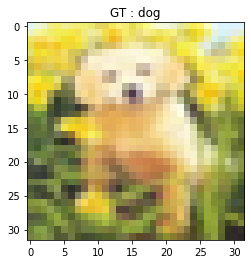

In [7]:
# Analysis of the test input 
#test_sample_index = np.random.randint(3000)
test_sample_index = 190
print('Random index ', test_sample_index)
test_input_temp = x_test[test_sample_index]

test_label = y_test[test_sample_index]
test_label_string = cifar_class_map.get(np.argmax(test_label))
ground_truth_prediction = np.argmax(test_label)

test_input = np.expand_dims(test_input_temp, axis=0)
#test_input = test_input/255.0
print('test_input shape :', test_input.shape)

plt.imshow(test_input[0])
plt.title(f'GT : {cifar_class_map.get(np.argmax(test_label))}')
plt.show()


## GBP Logic

In [8]:
def guided_bp(test_input, test_label, model, layer_name):
    @tf.custom_gradient
    def guidedRelu(x):
        #https://towardsdatascience.com/how-to-visually-explain-any-cnn-based-models-80e0975ce57
        def grad(dy):
            return tf.cast(dy>0,'float32') * tf.cast(x>0, 'float32') * dy
        return tf.nn.relu(x), grad

    normalized_gb_list = [] # collect the noramlized heatmaps of all the samples in a list 
    predicted_class_list = [] # to collect the prediction of all the samples in a list 
    LAYER_NAME = layer_name

    # create a model till last convolutional layers to have the best compromise between high-level semantics and detailed spatial information
    gb_model = tf.keras.models.Model(inputs = [model.input],    
                                     outputs = [model.get_layer(LAYER_NAME).output])
    
    #print('list of gbp_model layer name : ')
    #for i in gb_model.layers:
    #    print('layer_name_ ', i.name)
    
    #gb_model.summary()
    
    layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]
    #value = model.get_layer(LAYER_NAME).output.shape[-1]  # to compute the number of channels in the volume at a particular layer 

    for layer in layer_dict:
        if layer.activation == tf.keras.activations.relu:
            layer.activation = guidedRelu


    with tf.GradientTape() as tape:
        inputs = tf.cast(test_input, tf.float32)
        tape.watch(inputs)

        #outputs = gb_model.predict(inputs) 
        outputs = gb_model(inputs)
        #print('model prediction vector \n', outputs)
        #print('model prediction ', np.argmax(outputs))
        # essentially model() and model.predict() yield the same output with the difference that 
        # https://stackoverflow.com/questions/55308425/difference-between-modelx-and-model-predictx-in-keras#:~:text=The%20format%20may%20be%20different,its%20structure%2C%20weights%20and%20biases.
        #Today given a model in tensorflow 2.0 (built using the keras library), #out_np = model.predict(x) provides a numpy array which can, as an example, be printed with print(out_np).
        #On the other hand,out_tf = model(x) results into a tensorflow object, wich can be converted to a numpy array with .numpy()
        
        predicted_class = np.argmax(outputs)
        class_label = np.argmax(test_label)
        desired_class_logit = outputs[:, class_label]
        
        max_of_predicted_logits = outputs[:, predicted_class]
        #print('max of predicted logits : ', max_of_predicted_logits)
        print('prediction : ', predicted_class)
        print('GT : ', np.argmax(test_label))
        print('max of prediction logit ', max_of_predicted_logits)
        print('desired class logit ', desired_class_logit)
        
    #print('outputs[:, predicted_class] : ', outputs[:, predicted_class])
    grads = tape.gradient(max_of_predicted_logits, inputs)[0]# selecting that unit in dense layer that has the maximum activation for a given input,,,, if[0] not selected then shape of grads is: [1,32,32,3] 
    #grads = tape.gradient(desired_class_logit, inputs)[0]
    #print('grads shape : \n', grads.shape)

    return grads, predicted_class, desired_class_logit

## Generate GBP explanations

In [10]:
number_samples = 10 
count = 0
cmap='Greys'

alpha_im = 0
alpha_hm = 1

factor=1 # to stabilize the cv heatmap

number_of_explanations = 10

mean_gbp_explanation_across_epochs = []
std_gbp_explanation_across_epochs = []
list_of_gbp_desired_class_logit_across_epochs = []
list_of_gbp_output_across_epochs = []

#list_of_gbp_explanation_single_epoch = []
#list_of_gbp_output_single_epoch = [] 
#list_of_gbp_desired_class_logit_single_epoch = []

GBP_SSIM_mean = [] 
GBP_SSIM_std = [] 
GBP_desired_class_logit = []

for i in sorted_list_of_epochs:
    #print(i)
    model = tf.keras.models.load_model(os.path.join(model_path, i),
                                       custom_objects={'StochasticDropout':StochasticDropout})
    stochastic_model = StochasticClassifier(model, number_samples)
    
    list_of_gbp_explanation_single_epoch = [] 
    list_of_gbp_outputs_single_epoch = []
    list_of_gbp_desired_class_logit_single_epoch = []
    for explanation_id in range(number_of_explanations):
        gbp_explanation, prediction, desired_class_logit = guided_bp(test_input,
                                                test_label,
                                                stochastic_model,
                                                'dense_1')
        gbp_viz = np.dstack((gbp_explanation[:, :, 0],
                             gbp_explanation[:, :, 1],
                             gbp_explanation[:, :, 2]))
            
        gbp_viz = np.sqrt(gbp_viz[:, :, 0]**2 + gbp_viz[:, :, 1]**2 + gbp_viz[:, :, 2]**2)
        max_gbp_viz = np.max(gbp_viz)

        if max_gbp_viz == 0.0:
            normalized_gbp_viz = gbp_viz / (max_gbp_viz + 1e-5)
            #print('max normalized heat map : ', np.max(normalized_gbp_viz))

        else:
            normalized_gbp_viz = gbp_viz / max_gbp_viz 
        #print('normalized_gbp shape ', normalized_gbp_viz.shape)
        list_of_gbp_explanation_single_epoch.append(normalized_gbp_viz)
        list_of_gbp_outputs_single_epoch.append(prediction)
        list_of_gbp_desired_class_logit_single_epoch.append(desired_class_logit)
    gbp_explanation_single_epoch = np.array(list_of_gbp_explanation_single_epoch)
    # no need to compare the model prediction with ground truth as the explanation is calculated using the 
    # ground truth label and not with the model prediction 
    mean_explanation_per_epoch = np.mean(gbp_explanation_single_epoch, axis=0)
    std_explanation_per_epoch = np.std(gbp_explanation_single_epoch, axis=0)
    desired_class_logit_per_epoch = np.mean(list_of_gbp_desired_class_logit_single_epoch)
    
    mean_gbp_explanation_across_epochs.append(mean_explanation_per_epoch)
    std_gbp_explanation_across_epochs.append(std_explanation_per_epoch)
    list_of_gbp_desired_class_logit_across_epochs.append(desired_class_logit_per_epoch)
    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
print(list_of_gbp_desired_class_logit_across_epochs)

prediction :  5
GT :  5
max of prediction logit  tf.Tensor([0.27876088], shape=(1,), dtype=float32)
desired class logit  tf.Tensor([0.27876088], shape=(1,), dtype=float32)
prediction :  5
GT :  5
max of prediction logit  tf.Tensor([0.19070128], shape=(1,), dtype=float32)
desired class logit  tf.Tensor([0.19070128], shape=(1,), dtype=float32)
prediction :  2
GT :  5
max of prediction logit  tf.Tensor([0.20278007], shape=(1,), dtype=float32)
desired class logit  tf.Tensor([0.15269329], shape=(1,), dtype=float32)
prediction :  5
GT :  5
max of prediction logit  tf.Tensor([0.31335983], shape=(1,), dtype=float32)
desired class logit  tf.Tensor([0.31335983], shape=(1,), dtype=float32)
prediction :  5
GT :  5
max of prediction logit  tf.Tensor([0.27301267], shape=(1,), dtype=float32)
desired class logit  tf.Tensor([0.27301267], shape=(1,), dtype=float32)
prediction :  5
GT :  5
max of prediction logit  tf.Tensor([0.25737095], shape=(1,), dtype=float32)
desired class logit  tf.Tensor([0.257370

prediction :  5
GT :  5
max of prediction logit  tf.Tensor([0.9524421], shape=(1,), dtype=float32)
desired class logit  tf.Tensor([0.9524421], shape=(1,), dtype=float32)
prediction :  5
GT :  5
max of prediction logit  tf.Tensor([0.98885673], shape=(1,), dtype=float32)
desired class logit  tf.Tensor([0.98885673], shape=(1,), dtype=float32)
prediction :  5
GT :  5
max of prediction logit  tf.Tensor([0.9752349], shape=(1,), dtype=float32)
desired class logit  tf.Tensor([0.9752349], shape=(1,), dtype=float32)
prediction :  5
GT :  5
max of prediction logit  tf.Tensor([0.9766799], shape=(1,), dtype=float32)
desired class logit  tf.Tensor([0.9766799], shape=(1,), dtype=float32)
prediction :  5
GT :  5
max of prediction logit  tf.Tensor([0.85623175], shape=(1,), dtype=float32)
desired class logit  tf.Tensor([0.85623175], shape=(1,), dtype=float32)
prediction :  5
GT :  5
max of prediction logit  tf.Tensor([0.9992606], shape=(1,), dtype=float32)
desired class logit  tf.Tensor([0.9992606], sha

## Visualize GBP variation across epochs

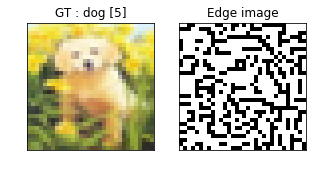

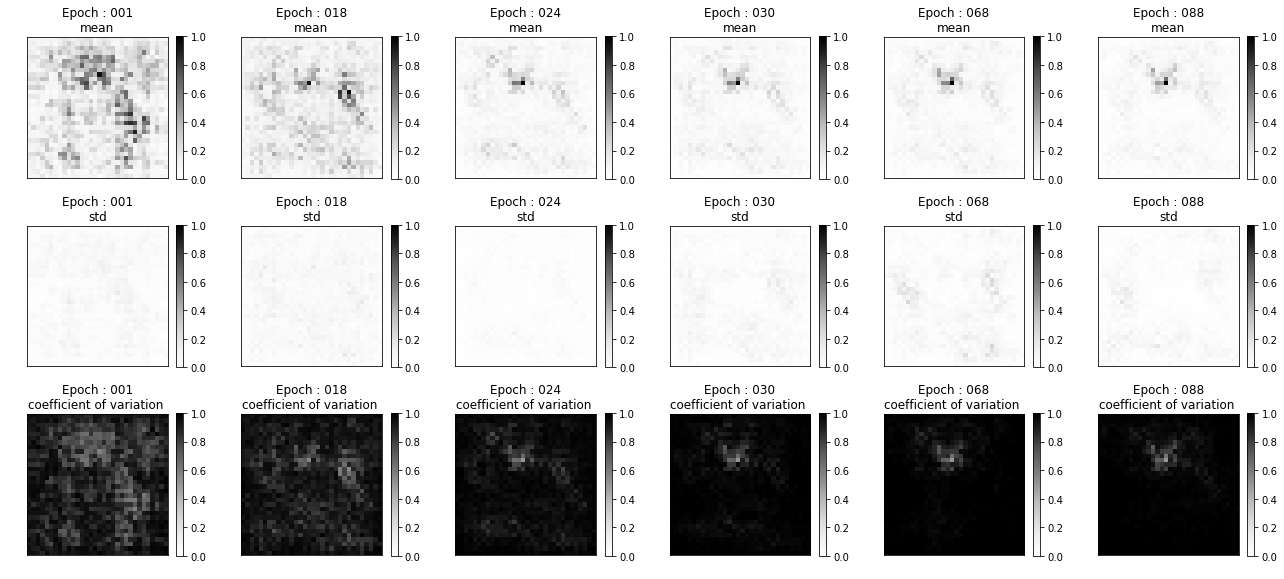

In [11]:
fig = plt.figure(figsize=(5, 3)) 
ax = fig.add_subplot(121)
ax.imshow(test_input_temp)
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
plt.title('GT : '+cifar_class_map.get(np.argmax(test_label))+' ['+str(np.argmax(test_label))+']')

ax = fig.add_subplot(122)
image = (test_input_temp*255).astype(np.uint8)
edge_image = cv2.Canny(image, 5, 5)
ax.imshow(edge_image, cmap='Greys')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
plt.title('Edge image')

plt.savefig(os.path.join(sanity_checks_output, 
                         'effect_of_epoch_original_image_new.png'))
plt.savefig(os.path.join(sanity_checks_output, 
                         'effect_of_epoch_original_image_new.pdf'))
plt.show()

#plt.imshow(test_input[0, :, :, :])
#plt.title(f'input image \nGT : {cifar_class_map.get(np.argmax(test_label))}')  
#plt.savefig(os.path.join(sanity_checks_output, 
#                         'effect_of_epoch_original_image.png'))
#plt.savefig(os.path.join(sanity_checks_output, 
#                         'effect_of_epoch_original_image.pdf'))
#plt.show()
    

for i in range(len(list_of_epoch_number)):
    # following few lines compute the SSIM 
    
    # get the best epochs mean and std 
    mean_explanation_best_epoch = np.expand_dims(mean_gbp_explanation_across_epochs[-1], axis=0)
    mean_explanation_best_epoch = np.expand_dims(mean_explanation_best_epoch, axis=-1)
    std_explanation_best_epoch = np.expand_dims(std_gbp_explanation_across_epochs[-1], axis=0)
    std_explanation_best_epoch = np.expand_dims(std_explanation_best_epoch, axis=-1)
    
    # get the current epochs mean and std 
    mean_explanation_intermediate_epoch = np.expand_dims(mean_gbp_explanation_across_epochs[i], axis=0)
    mean_explanation_intermediate_epoch = np.expand_dims(mean_explanation_intermediate_epoch, axis=-1)
    std_explanation_intermediate_epoch = np.expand_dims(std_gbp_explanation_across_epochs[i], axis=0)
    std_explanation_intermediate_epoch = np.expand_dims(std_explanation_intermediate_epoch, axis=-1)
    
    mean_ssim = tf.image.ssim(mean_explanation_best_epoch, 
                         mean_explanation_intermediate_epoch, 
                         max_val=1.0, 
                         filter_size=11,
                         filter_sigma=1.5, 
                         k1=0.01, 
                         k2=0.03)
    
    std_ssim = tf.image.ssim(std_explanation_best_epoch, 
                         std_explanation_intermediate_epoch, 
                         max_val=1.0, 
                         filter_size=11,
                         filter_sigma=1.5, 
                         k1=0.01, 
                         k2=0.03)
    
    GBP_SSIM_mean.append(mean_ssim)
    GBP_SSIM_std.append(std_ssim)
    GBP_desired_class_logit.append(list_of_gbp_desired_class_logit_across_epochs[i])
    
fig = plt.figure(figsize=(18, 8))
#for i, j in zip(mean_ig_explanation_across_epochs, std_ig_explanation_across_epochs):
for i in range(len(sorted_list_of_epochs)):
   
    cv_heatmap = (std_gbp_explanation_across_epochs[i] + factor) / (mean_gbp_explanation_across_epochs[i] + factor)

    ax = plt.subplot(3, len(sorted_list_of_epochs), i+1)
    ax.imshow(test_input[0, :, :, :], alpha=alpha_im)
    hm = plt.imshow(mean_gbp_explanation_across_epochs[i], alpha=alpha_hm, cmap=cmap, vmax=1, vmin=0)
    plt.colorbar(hm)
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    plt.title(f'Epoch : {list_of_epoch_number[i]}\nmean')
    
    
    ax = plt.subplot(3, len(sorted_list_of_epochs), i+1+len(sorted_list_of_epochs))
    ax.imshow(test_input[0, :, :, :], alpha=alpha_im)  
    hm = plt.imshow(std_gbp_explanation_across_epochs[i], alpha=alpha_hm, cmap=cmap, vmax=1, vmin=0)
    plt.colorbar(hm)
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    plt.title(f'Epoch : {list_of_epoch_number[i]}\nstd')
    
    ax = plt.subplot(3, len(sorted_list_of_epochs), i+1+2*len(sorted_list_of_epochs))
    ax.imshow(test_input[0, :, :, :], alpha=alpha_im)  
    hm = plt.imshow(cv_heatmap, alpha=alpha_hm, cmap=cmap, vmax=1, vmin=0)
    plt.colorbar(hm)
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    plt.title(f'Epoch : {list_of_epoch_number[i]}\ncoefficient of variation ')
    
    
plt.tight_layout()    
#plt.title('Variation of mean and std heatmap with epochs')
plt.savefig(os.path.join(sanity_checks_output, 'effect_of_epoch_GBP_new.png'))
plt.savefig(os.path.join(sanity_checks_output, 'effect_of_epoch_GBP_new.pdf'))
plt.show()   

## IG Logic

In [12]:
class IntegratedGradient:
    def visualize_input_to_be_explained(self, test_input, test_label):
        # source : https://www.tensorflow.org/tutorials/interpretability/integrated_gradients

        # selecting a sample to explain 
        #test_sample_index=np.random.randint(3000)
        #test_input_temp = x_test[test_sample_index]
        #test_input_temp_norm = test_input_temp/255.0

        #print('image pixel values ', test_input_temp_norm)
        #test_label = y_test[test_sample_index]
        #test_label_string = cifar_class_map.get(np.argmax(test_label))
        #ground_truth = np.argmax(test_label)

        # show the selected sample
        #plt.subplot(121)
        #plt.imshow(test_input)
        #plt.title('GT : '+cifar_class_map.get(np.argmax(test_label))+' ['+str(np.argmax(test_label))+']')
      
        #test_input = tf.expand_dims(test_input_temp, axis=0)

        # plot the baseline
        baseline = np.zeros(shape=(32,32,3))  # shape similar to that of input 

        #plt.subplot(122)
        #plt.imshow(baseline)
        #plt.title("Baseline")
        #plt.axis('off')
        #plt.show()
        return baseline


    def generating_interpolated_images(self, baseline, image, m_steps):
        # generating interpolated images
        m_steps=m_steps
        alphas = np.linspace(start=0.0, stop=1.0, num=m_steps+1) # Generate m_steps intervals for integral_approximation() below.
        alphas_x = alphas[:, np.newaxis, np.newaxis, np.newaxis]

        baseline_x = np.expand_dims(baseline, axis=0)
        baseline_x = np.ndarray.astype(baseline_x, dtype=np.float32)

        input_x = np.expand_dims(image, axis=0)
        input_x = np.ndarray.astype(input_x, dtype=np.float32)

        delta = input_x - baseline_x
        images = baseline_x +  alphas_x * delta
        return alphas, images


    def visualize_interpolated_images(self, alphas, images):
        #convert numpy images to tensor
        #interpolated_images_tensor = tf.convert_to_tensor(interpolated_images)
        fig = plt.figure(figsize=(20, 20))
        i = 0
        print('alphas ', alphas[0::10])
        for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
            i += 1
            plt.subplot(1, len(alphas[0::10]), i)
            plt.title(f'alpha: {alpha:.1f}')
            #image_int = tf.cast(image, tf.int32)
            plt.imshow(image)
            plt.axis('off')

        plt.tight_layout()
        plt.show()

    
    def compute_gradients(self, images, ground_truth, stoch_model):
        model = tf.keras.models.Model(inputs=[stoch_model.input],
                                      outputs=[stoch_model.output])    #this step done in order to avoid the 'IteratorGetNext' error 
        #images_adj = tf.squeeze(images, axis=0)  # images have a shape of (1, 51, 32, 32, 3), but model accepts (None, 51, 51, 3) therefore need to squeeze it
        images_adj = tf.convert_to_tensor(images, dtype=tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(images_adj)
            outputs = model(images_adj)  # this is a (51, 10) vector that contains the predictions for the intermediate images in the form of softmax output
            class_prediction = tf.math.argmax(outputs, axis=1)
            max_output_predictions = tf.math.reduce_max(outputs, axis=1)
            desired_class_logit = outputs[:, np.argmax(ground_truth)]
            #print(desired_class_logit.shape)
            
 
        #probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
        #desired_class_logit = outputs[: ,class_prediction]
        #gradients = tape.gradient(desired_class_logit, images_adj)
        gradients = tape.gradient(max_output_predictions, images_adj)
        #print('gradients shape ', gradients.shape)
        #print('class prediction : ', class_prediction)
        class_prediction_np = list(class_prediction.numpy())   # for the ease of handling the output predictions
        #print('class prediction list : ', class_prediction_np)
        print('IG max output prediction logit ', np.mean(max_output_predictions))
        print('IG desired class logit ', np.mean(desired_class_logit))
        class_prediction_for_a_single_batch = max(set(class_prediction_np), key=class_prediction_np.count)          # https://stackoverflow.com/questions/1518522/find-the-most-common-element-in-a-list
        #print('gradients ', gradients)
        #print('gradients shape : ', gradients.shape)
        #return tape.gradient(probs, images)  #original example had shape of (51, 224, 224, 3)
        return class_prediction_for_a_single_batch, gradients, np.mean(desired_class_logit)


    def integral_approximation(self, gradients):
        # riemann_trapezoidal
        grads = (gradients[:-1] + gradients[1:]) / 2.0
        integrated_gradients = np.mean(grads, axis=0)
        return integrated_gradients


    def one_batch(self, baseline, image, ground_truth, alpha_batch, model, m_steps):
        # Generate interpolated inputs between baseline and input.
        interpolated_path_input_batch = self.generating_interpolated_images(baseline=baseline,
                                                                            image=image,
                                                                            m_steps=m_steps)[-1]    # since this function returns 4 arguments and here only the 4th is useful
                                                                                                   # this will return (1, 51, 32, 32, 3) 
        # Compute gradients between model outputs and interpolated inputs.
        class_prediction, gradient_batch, desired_class_logit_one_batch = self.compute_gradients(images=interpolated_path_input_batch, 
                                                                  ground_truth=ground_truth, 
                                                                  stoch_model=model)
                                        
        return class_prediction, gradient_batch, desired_class_logit_one_batch

    
    def integrated_gradients(self, 
                             baseline,
                             image,
                             ground_truth,
                             m_steps=None,
                             batch_size=None,
                             model=None):
        
        # Generate alphas.
        alphas = np.linspace(start=0.0, stop=1.0, num=m_steps+1)

        # Collect gradients.    
        gradient_batches = []
        prediction_output_for_batches = [] 
        desired_class_logit_for_batches = [] 
        

        # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
        for alpha in range(0, len(alphas), batch_size):
            from_ = alpha
            to = np.minimum(from_ + batch_size, len(alphas))
            alpha_batch = alphas[from_:to]
            #print('alpha batches :', alpha_batch)

            #print('image to be explained \n ', image)

            prediction, gradient_batch, desired_class_logit = self.one_batch(baseline, image, ground_truth, alpha_batch, model, m_steps)
            gradient_batches.append(gradient_batch)
            prediction_output_for_batches.append(prediction)
            desired_class_logit_for_batches.append(desired_class_logit) 
            
        # Concatenate path gradients together row-wise into single tensor.
        total_gradients = np.concatenate(gradient_batches, axis=0)
        #print('total gradients shape : ', total_gradients.shape)

        # Integral approximation through averaging gradients.
        avg_gradients = self.integral_approximation(gradients=total_gradients)
        #print('avg gradients shape : ', avg_gradients.shape)

        # Scale integrated gradients with respect to input.
        integrated_gradients = (image - baseline) * avg_gradients
        
        desired_class_logit = np.mean(desired_class_logit_for_batches)
        print('IG desired class logit ', np.mean(desired_class_logit))

        # identify the majority prediction in individual batch 

        #print('prediction_output_for_batches ', prediction_output_for_batches)

        return prediction_output_for_batches, integrated_gradients, desired_class_logit


    def plot_img_attributions(self, 
                              baseline,
                              image,
                              ground_truth,
                              m_steps=None,
                              model=None):

        prediction_majority_per_batch, attributions, desired_class_logit = self.integrated_gradients(baseline=baseline,
                                                 image=image,
                                                 ground_truth=ground_truth,
                                                 batch_size=batch_size,
                                                 m_steps=m_steps,
                                                 model=model)
        
        #print('prediction majority per batch : ', prediction_majority_per_batch)
        prediction_majority_per_batch = [int(i[0]) if i.shape!=() else int(i) for i in prediction_majority_per_batch]
        #print('prediction majority per batch : ', prediction_majority_per_batch)

        
        prediction = max(set(prediction_majority_per_batch), key=prediction_majority_per_batch.count)

        #print('attributions shape : ', attributions.shape)
        #print('baseline shape : ', baseline.shape)
        #attributions = tf.squeeze(attributions, axis=0)
        #baseline = tf.squeeze(baseline, axis=0)


        #print('raw attributions : ', attributions)
        #print('attributions shape : ', attributions.shape)
        #print('baseline shape : ', baseline.shape)
        #print('image shape : ', image.shape)
        #print('prediction_majority_per_batch : ', prediction_majority_per_batch)

        #attributions_np = attributions.numpy()

        attributions_viz = np.dstack((attributions[:, :, 0],
                                      attributions[:, :, 1],   # https://towardsdatascience.com/how-to-visually-explain-any-cnn-based-models-80e0975ce57
                                      attributions[:, :, 2],
                    ))      

        #computing magnitude across channels 
        attributions_viz = np.sqrt(attributions_viz[:, :, 0]**2 + attributions_viz[:, :, 1]**2 + attributions_viz[:, :, 2]**2)
        #print('attributions_viz ', attributions_viz)
        #print('attributions_viz shape : ', attributions_viz.shape)

        max_attributions_viz = np.max(attributions_viz)   # extracting the maximum value of heatmap generated by a individual model comprising the ensemble
       
        
        normalized_attributions_viz = attributions_viz / max_attributions_viz  # normalizing individual heatmaps as per corresponding maximum value

        #print('attributions_viz normalized ', normalized_attributions_viz)
        
        #print('maximum value in normalized heatmap number : ', i, ' ', np.max(normalized_attributions_viz)) 

        #print('maximum value in unnormalized heatmap number : ', i, ' ', np.max(attributions_viz))   # printing the maximum value before normalizing
        

        #ORIGINAL CODE 
        # Sum of the attributions across color channels for visualization.
        # The attribution mask shape is a grayscale image with height and width
        # equal to the original image.
        #attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)
        #attribution_mask_norm = attribution_mask/tf.math.reduce_max(attribution_mask)
        print('GT : ', np.argmax(ground_truth))
        #print('prediction : ', prediction)
        #print('desired class logit : ', desired_class_logit)
         
        return baseline, image, prediction, attributions_viz, normalized_attributions_viz, desired_class_logit

## Generate IG explanations

In [13]:
m_steps = 50 
batch_size = 26 

mean_ig_explanation_across_epochs = []
std_ig_explanation_across_epochs = []
list_of_ig_desired_class_logit_across_epochs = []
list_of_ig_output_across_epochs = []

#list_of_ig_explanation_single_epoch = []
#list_of_ig_output_single_epoch = [] 
#list_of_ig_desired_class_logit_single_epoch = [] 

IG_SSIM_mean = [] 
IG_SSIM_std = [] 
IG_desired_class_logit = []

ig_explainer = IntegratedGradient() 

for i in sorted_list_of_epochs:
    model = tf.keras.models.load_model(os.path.join(model_path, i),
                                       custom_objects={'StochasticDropout':StochasticDropout})
    stochastic_model = StochasticClassifier(model, number_samples)
    
    list_of_ig_explanation_single_epoch = [] 
    list_of_ig_outputs_single_epoch = []
    list_of_ig_desired_class_logit_single_epoch = [] 
    
    for explanation_id in range(number_of_explanations):
        baseline = ig_explainer.visualize_input_to_be_explained(test_input[0, :, :, :], 
                                                                test_label)
            
        alphas, interpolated_images = ig_explainer.generating_interpolated_images(baseline=baseline,
                                                                                  image=test_input[0, :, :, :], 
                                                                                  m_steps=m_steps)
            
        baseline_im, image_to_be_explained, prediction, ig_explanation, ig_explanation_normalized, desired_class_logit_per_explanation = ig_explainer.plot_img_attributions(baseline=baseline,
                                                                                                                            image=test_input[0, :, :, :],
                                                                                                                            ground_truth=test_label,
                                                                                                                            m_steps=m_steps,
                                                                                                                            model=stochastic_model)
                                                                                                                                                                     
                
        list_of_ig_explanation_single_epoch.append(ig_explanation_normalized)
        list_of_ig_outputs_single_epoch.append(prediction)
        list_of_ig_desired_class_logit_single_epoch.append(desired_class_logit_per_explanation)
        print('single_epoch IG explanation ', list_of_ig_desired_class_logit_single_epoch)
        
    
    ig_explanation_single_epoch = np.array(list_of_ig_explanation_single_epoch)
        
    # no need to compare the model prediction with ground truth as the explanation is calculated using the 
    # ground truth label and not with the model prediction 
    mean_explanation_per_epoch = np.mean(ig_explanation_single_epoch, axis=0)
    std_explanation_per_epoch = np.std(ig_explanation_single_epoch, axis=0)
    
    mean_ig_explanation_across_epochs.append(mean_explanation_per_epoch)
    std_ig_explanation_across_epochs.append(std_explanation_per_epoch)
    list_of_ig_desired_class_logit_across_epochs.append(np.mean(list_of_ig_desired_class_logit_single_epoch))
    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
print(list_of_ig_desired_class_logit_across_epochs)

IG max output prediction logit  0.41962355
IG desired class logit  0.104947045
IG max output prediction logit  0.41942698
IG desired class logit  0.095673196
IG desired class logit  0.10031012
GT :  5
single_epoch IG explanation  [0.10031012]
IG max output prediction logit  0.4273595
IG desired class logit  0.11373292
IG max output prediction logit  0.45479402
IG desired class logit  0.113750495
IG desired class logit  0.11374171
GT :  5
single_epoch IG explanation  [0.10031012, 0.11374171]
IG max output prediction logit  0.42586908
IG desired class logit  0.10411472
IG max output prediction logit  0.41854724
IG desired class logit  0.10667596
IG desired class logit  0.10539534
GT :  5
single_epoch IG explanation  [0.10031012, 0.11374171, 0.10539534]
IG max output prediction logit  0.43098375
IG desired class logit  0.1064419
IG max output prediction logit  0.420275
IG desired class logit  0.11561562
IG desired class logit  0.11102876
GT :  5
single_epoch IG explanation  [0.10031012, 0

IG desired class logit  0.14098749
IG max output prediction logit  0.66347104
IG desired class logit  0.13206206
IG desired class logit  0.13652477
GT :  5
single_epoch IG explanation  [0.13652477]
IG max output prediction logit  0.68630123
IG desired class logit  0.16146149
IG max output prediction logit  0.6455201
IG desired class logit  0.112130836
IG desired class logit  0.13679616
GT :  5
single_epoch IG explanation  [0.13652477, 0.13679616]
IG max output prediction logit  0.65646243
IG desired class logit  0.17977734
IG max output prediction logit  0.59170264
IG desired class logit  0.18466039
IG desired class logit  0.18221886
GT :  5
single_epoch IG explanation  [0.13652477, 0.13679616, 0.18221886]
IG max output prediction logit  0.6553003
IG desired class logit  0.11748944
IG max output prediction logit  0.66288894
IG desired class logit  0.12096061
IG desired class logit  0.119225025
GT :  5
single_epoch IG explanation  [0.13652477, 0.13679616, 0.18221886, 0.119225025]
IG max

## Visualize IG variation across epochs

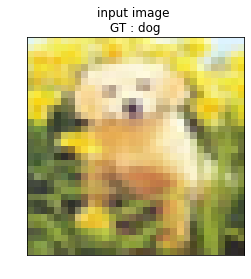

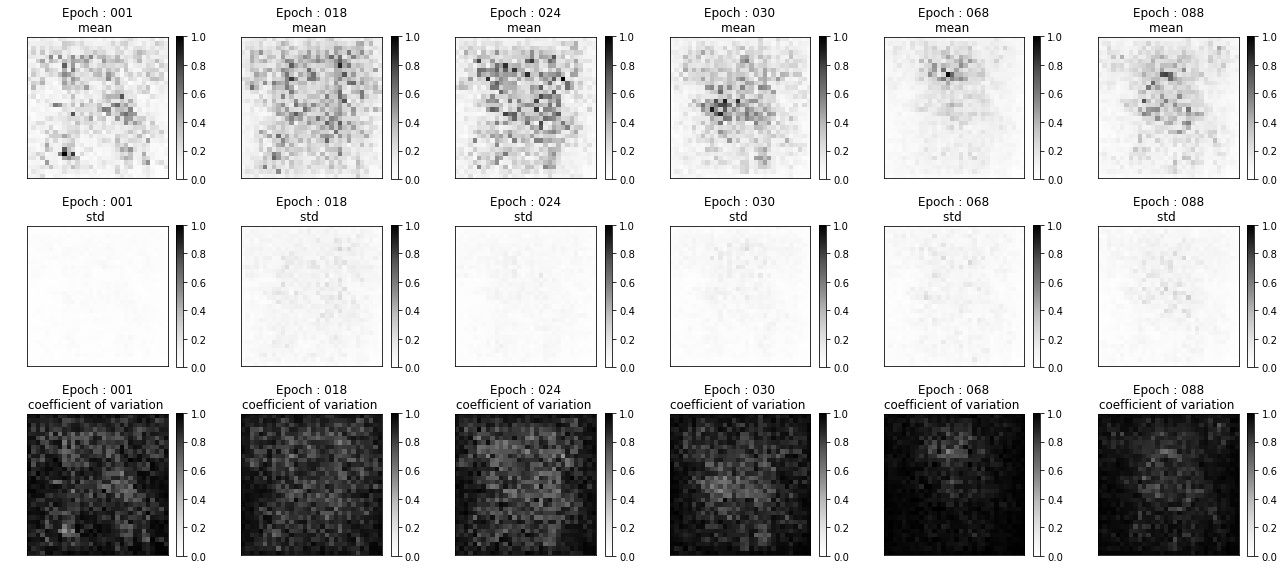

In [14]:
fig = plt.figure() 
ax = fig.add_subplot(111)
ax.imshow(test_input[0, :, :, :])
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
plt.title(f'input image \nGT : {cifar_class_map.get(np.argmax(test_label))}')  
#plt.savefig(os.path.join(sanity_checks_output, 'effect_of_epoch_original_image.png'))
#plt.savefig(os.path.join(sanity_checks_output, 'effect_of_epoch_original_image.pdf'))
plt.show()
    

for i in range(len(list_of_epoch_number)):
    # following few lines compute the SSIM 
    
    # get the best epochs mean and std 
    mean_explanation_best_epoch = np.expand_dims(mean_ig_explanation_across_epochs[-1], axis=0)
    mean_explanation_best_epoch = np.expand_dims(mean_explanation_best_epoch, axis=-1)
    std_explanation_best_epoch = np.expand_dims(std_ig_explanation_across_epochs[-1], axis=0)
    std_explanation_best_epoch = np.expand_dims(std_explanation_best_epoch, axis=-1)
    
    # get the current epochs mean and std 
    mean_explanation_intermediate_epoch = np.expand_dims(mean_ig_explanation_across_epochs[i], axis=0)
    mean_explanation_intermediate_epoch = np.expand_dims(mean_explanation_intermediate_epoch, axis=-1)
    std_explanation_intermediate_epoch = np.expand_dims(std_ig_explanation_across_epochs[i], axis=0)
    std_explanation_intermediate_epoch = np.expand_dims(std_explanation_intermediate_epoch, axis=-1)
    
    
    mean_ssim = tf.image.ssim(mean_explanation_best_epoch, 
                         mean_explanation_intermediate_epoch, 
                         max_val=1.0, 
                         filter_size=11,
                         filter_sigma=1.5, 
                         k1=0.01, 
                         k2=0.03)
    
    std_ssim = tf.image.ssim(std_explanation_best_epoch, 
                         std_explanation_intermediate_epoch, 
                         max_val=1.0, 
                         filter_size=11,
                         filter_sigma=1.5, 
                         k1=0.01, 
                         k2=0.03)
    
    IG_SSIM_mean.append(mean_ssim)
    IG_SSIM_std.append(std_ssim)
    IG_desired_class_logit.append(list_of_ig_desired_class_logit_across_epochs[i])
    
fig = plt.figure(figsize=(18, 8))
#for i, j in zip(mean_ig_explanation_across_epochs, std_ig_explanation_across_epochs):
for i in range(len(sorted_list_of_epochs)):
   
    cv_heatmap = (std_ig_explanation_across_epochs[i] + factor) / (mean_ig_explanation_across_epochs[i] + factor)
    ax = plt.subplot(3, len(sorted_list_of_epochs), i+1)
    plt.imshow(test_input[0, :, :, :], alpha=alpha_im)
    hm = ax.imshow(mean_ig_explanation_across_epochs[i], alpha=alpha_hm, cmap=cmap, vmax=1, vmin=0)
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    plt.colorbar(hm)
    plt.title(f'Epoch : {list_of_epoch_number[i]}\nmean ')
    
    ax = plt.subplot(3, len(sorted_list_of_epochs), i+1+len(sorted_list_of_epochs))
    plt.imshow(test_input[0, :, :, :], alpha=alpha_im)  
    hm = ax.imshow(std_ig_explanation_across_epochs[i], alpha=alpha_hm, cmap=cmap, vmax=1, vmin=0)
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    plt.colorbar(hm)
    plt.title(f'Epoch : {list_of_epoch_number[i]}\nstd ')
    
    ax = plt.subplot(3, len(sorted_list_of_epochs), i+1+2*len(sorted_list_of_epochs))
    ax.imshow(test_input[0, :, :, :], alpha=alpha_im)  
    hm = plt.imshow(cv_heatmap, alpha=alpha_hm, cmap=cmap, vmax=1, vmin=0)
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    plt.colorbar(hm)
    plt.title(f'Epoch : {list_of_epoch_number[i]}\ncoefficient of variation ')
    
plt.tight_layout()  
#plt.title('Variation of mean and std heatmap with epochs')
plt.savefig(os.path.join(sanity_checks_output, 'effect_of_epoch_IG_new.png'))
plt.savefig(os.path.join(sanity_checks_output, 'effect_of_epoch_IG_new.pdf'))
plt.show()    

## Comparison SSIM

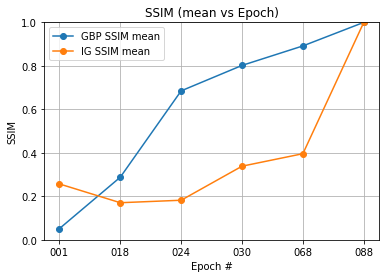

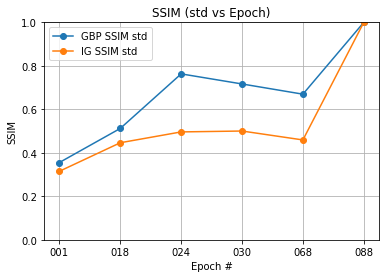

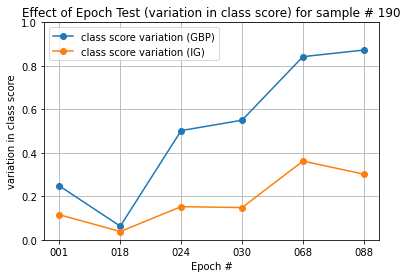

In [15]:
[int(i) for i in list_of_epoch_number]

plt.plot(list_of_epoch_number, GBP_SSIM_mean, 'o-', label='GBP SSIM mean')
plt.plot(list_of_epoch_number, IG_SSIM_mean,  'o-', label='IG SSIM mean')
plt.xlabel('Epoch #')
plt.ylabel('SSIM')
plt.ylim(0, 1)
plt.grid()
plt.title(f'SSIM (mean vs Epoch)')
plt.legend()
plt.savefig(os.path.join(sanity_checks_output, 'effect_of_epoch_mean_SSIM_comparison_new.png'))
plt.savefig(os.path.join(sanity_checks_output, 'effect_of_epoch_mean_SSIM_comparison_new.pdf'))

plt.show() 
    
#[int(i) for i in list_of_epoch_number]

plt.plot(list_of_epoch_number, GBP_SSIM_std, 'o-', label='GBP SSIM std')
plt.plot(list_of_epoch_number, IG_SSIM_std, 'o-', label='IG SSIM std')
plt.xlabel('Epoch #')
plt.ylabel('SSIM')
plt.ylim(0, 1)
plt.grid()
plt.title(f'SSIM (std vs Epoch)')
plt.legend()
plt.savefig(os.path.join(sanity_checks_output, 'effect_of_epoch_std_SSIM_comparison_new.png'))
plt.savefig(os.path.join(sanity_checks_output, 'effect_of_epoch_std_SSIM_comparison_new.pdf'))
plt.show()

plt.plot(list_of_epoch_number, GBP_desired_class_logit, 'o-', label='class score variation (GBP)')
plt.plot(list_of_epoch_number, IG_desired_class_logit, 'o-', label='class score variation (IG)')
plt.xlabel('Epoch #')
plt.ylabel('variation in class score')
plt.ylim(0, 1)
plt.grid()
plt.title(f'Effect of Epoch Test (variation in class score) for sample # {test_sample_index}')
plt.legend()
plt.savefig(os.path.join(sanity_checks_output, 'effect_of_epoch_desired_class_score_comparison_new.png'))
plt.savefig(os.path.join(sanity_checks_output, 'effect_of_epoch_desired_class_score_comparison_new.pdf'))
plt.show()